# cleanup data and store for latter processing

- Clean up Atalante data
- There are spikes in conductivity for station "s0_1": redo seabird processing or correct a posteriori ?


### plot: focus on Plume

### plot: focus on Plume

In [3]:
import os
from glob import glob

import numpy as np
import pandas as pd
import xarray as xr

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
import hvplot.xarray  # noqa
import hvplot.pandas  # noqa
import cmocean.cm as cm

import pynsitu as pin

crs = pin.maps.crs

/Users/aponte/.miniconda3/envs/pynsitu/lib/python3.10/site-packages/pyTMD/tools.py:55: UserWarning: ipyleaflet not available
  warnings.warn("ipyleaflet not available")
/Users/aponte/.miniconda3/envs/pynsitu/lib/python3.10/site-packages/pyTMD/tools.py:56: UserWarning: Some functions will throw an exception if called
  warnings.warn("Some functions will throw an exception if called")


---
## load campaign info

In [4]:
campaign = "drixmed22"
root_dir = "/Users/aponte/Code/drix_analysis/" + campaign
yaml = f"{campaign}.yaml"

# load campaign object
cp = pin.campaign(os.path.join(root_dir, yaml))

# plotting utils
kwargs_map = dict(extent=cp.lon + cp.lat, bathy=cp.bathy["label"])

underway
tide_gauge
adcp_europe
adcp_drix
ctd_europe
ctd_drix
0-4350125
0-4352044
0-4350124
0-4352185
0-4351896
0-4352181


---

## load ctd casts and store

The casts have cleaned up with seabird softwares

In [5]:
ctd = "mio"
partial_path = f"ctd_{ctd}_cast*.cnv"
u = "ctd_europe"

In [ ]:
def read_ctd_file(file, ctd, u, raw=False):

    # load file
    with open(file) as f:
        d = list(f.readlines())
    d = [l.strip("\n") for l in d]

    # start parsing header and body
    i = 0
    while "*END*" not in d[i]:
        i += 1
    header = d[: i + 1]
    body = d[i + 1 :]

    # split each line into a list
    body = [l.split() for l in body]

    # remove some empty rows
    # d = [v for v in d if len(v) > 1]

    ### mio - clean data:
    # name 0 = scan: Scan Count
    # name 1 = prdM: Pressure, Strain Gauge [db]
    # name 2 = tv290C: Temperature [ITS-90, deg C]
    # name 3 = c0mS/cm: Conductivity [mS/cm]
    # name 4 = wetStar: Fluorescence, WET Labs WETstar [mg/m^3]
    # name 5 = seaTurbMtr: Turbidity, Seapoint [FTU]
    # name 6 = timeJ: Julian Days
    # name 7 = timeH: Time, Elapsed [hours]
    # name 8 = timeM: Time, Elapsed [minutes]
    # name 9 = timeS: Time, Elapsed [seconds]
    # name 10 = gsw_densityA0: density, TEOS-10 [density, kg/m^3]
    # name 11 = gsw_sigma0A0: density, TEOS-10 [sigma-0, kg/m^3 ]
    # name 12 = gsw_ssA0: sound speed, TEOS-10 [m/s]
    # name 13 = flag: flag

    ### mio - raw:
    # name 0 = scan: Scan Count
    # name 1 = prdM: Pressure, Strain Gauge [db]
    # name 2 = tv290C: Temperature [ITS-90, deg C]
    # name 3 = c0mS/cm: Conductivity [mS/cm]
    # name 4 = wetStar: Fluorescence, WET Labs WETstar [mg/m^3]
    # name 5 = seaTurbMtr: Turbidity, Seapoint [FTU]
    # name 6 = timeJ: Julian Days
    # name 7 = timeH: Time, Elapsed [hours]
    # name 8 = timeM: Time, Elapsed [minutes]
    # name 9 = timeS: Time, Elapsed [seconds]
    # name 10 = flag:  0.000e+00

    if ctd == "mio" and not raw:
        columns = [
            "scan",
            "pressure",
            "temperature",
            "conductivity",
            "fluorescence",
            "turbidity",
            "julian_days",
            "hour",
            "minute",
            "second",
            "density",
            "sigma0",
            "sound_speed",
            "flat",
        ]
        dtypes = [int] + [float] * 13
    elif ctd == "mio" and raw:
        columns = [
            "scan",
            "pressure",
            "temperature",
            "conductivity",
            "fluorescence",
            "turbidity",
            "julian_days",
            "hour",
            "minute",
            "second",
            "flat",
        ]
        dtypes = [int] + [float] * 9

    df = pd.DataFrame(body, columns=columns)
    for c, dtype in zip(df.columns, dtypes):
        df[c] = df[c].astype(dtype)

    # julian day has anomalous values ...
    # 1 day offset
    # df["time"] = pd.Timestamp("2022/01/01") + pd.to_timedelta(df["julian_days"]-1, "D") # not so sure about the 1 days offset ...
    #
    # use seconds instead
    _lines = [l for l in header if "start_time" in l]
    assert len(_lines) == 1, ("more than two potential lines", _lines)
    start_time = pd.to_datetime(
        _lines[0].split("=")[1].split("[")[0].strip(), format="%b %d %Y %H:%M:%S"
    )
    df["time"] = start_time + pd.to_timedelta(df["second"], "s")
    df = df.drop(columns=["julian_days", "hour", "minute", "second"])

    # get position from yml file, alternative is use underway data
    station = find_station(u, df["time"][0])
    attrs = dict(
        station=station,
        time=cp[u][station].start.time,
        lon=cp[u][station].start.lon,
        lat=cp[u][station].start.lat,
    )
    df.attrs.update(**attrs)
    df.lon = attrs["lon"]
    df.lat = attrs["lat"]

    df.sw.update_eos()  # in place

    return df


def find_station(u, t):
    delta = pd.Series(
        [abs(d.start.time - t) for d in cp[u]], index=[d.label for d in cp[u]]
    )
    return delta.idxmin()

In [ ]:
get_cast_numbers = lambda f: int(
    f.split("/")[-1].split("_")[-1].replace("cast", "").replace(".cnv", "")
)

files = sorted(
    glob(os.path.join(cp.pathr, "CTD/" + partial_path)), key=get_cast_numbers
)

# raw files
files_raw = sorted(
    glob(os.path.join(cp.pathr, "CTD/raw/" + partial_path)), key=get_cast_numbers
)

### inspect one cast

In [ ]:
# file = files[0]
# df = read_ctd_file(file, ctd, u)

file = files_raw[0]
df = read_ctd_file(file, ctd, u, raw=True)
print(f"station label: " + df.attrs["station"])
df.head()

In [ ]:
df.sw.plot_bokeh(cross=False)

In [ ]:
df["conductivity"].hvplot()

### load all files and store into netcdf files

In [ ]:
# D = dict()
for file in files:
    df = read_ctd_file(file, ctd, u)
    d = df.attrs["station"]
    # D[d] = df
    ds = df.to_xarray()
    ds.attrs.update(df.attrs)
    ds.attrs.pop("time")
    ds.to_netcdf(os.path.join(cp.pathp, f"{u}_{d}.nc"), mode="w")

## plot overview of the casts

### reload data

In [6]:
D = dict()
for d in cp[u]:
    ds = cp.load(f"{u}_{d.label}.nc")
    ds = ds.assign_coords(z=-ds.depth)
    # .expand_dims(cast=[d.label])
    D[d.label] = ds

# merge into one dataset
# ds = xr.concat([ds for d, ds in D.items()], "cast")

### maps

In [7]:
# load europe underway data
europe = cp.load("europe_underway_10s.nc").set_coords(["lon", "lat"])
da = europe.salinity

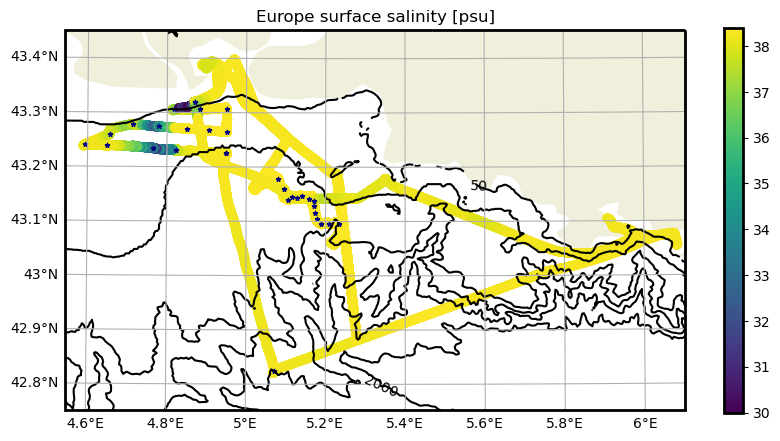

In [8]:
# global map

fac = pin.maps.plot_map(**kwargs_map, bathy_levels=cp.bathy["levels"])
fig, ax = fac["fig"], fac["ax"]
im = ax.scatter(da.lon, da.lat, c=da, transform=crs, vmin=30)
fig.colorbar(im, ax=ax)
ax.set_title("Europe surface salinity [psu]")

ax.scatter(
    [d.start.lon for d in cp["ctd_europe"]],
    [d.start.lat for d in cp["ctd_europe"]],
    s=10,
    c="navy",
    edgecolor=None,
    marker="*",
    transform=crs,
)

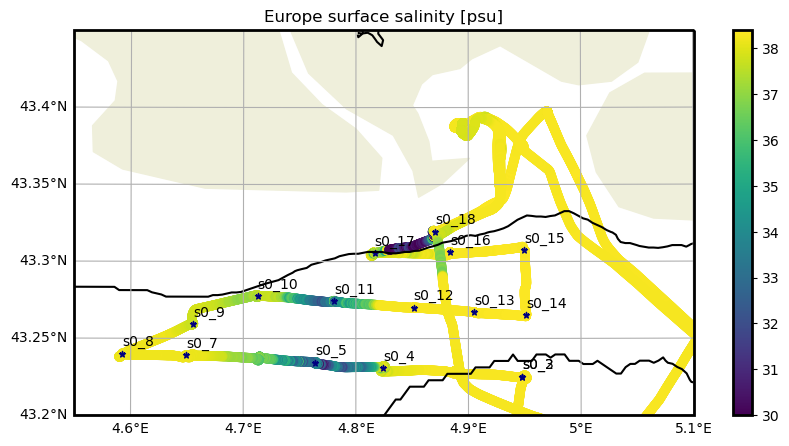

In [9]:
# plume area

kwargs_plume = dict(extent=(4.55, 5.1, 43.2, 43.45), bathy=kwargs_map["bathy"])

fac = pin.maps.plot_map(**kwargs_plume, bathy_levels=cp.bathy["levels"])
fig, ax = fac["fig"], fac["ax"]
im = ax.scatter(da.lon, da.lat, c=da, transform=crs, vmin=30)
fig.colorbar(im, ax=ax)
ax.set_title("Europe surface salinity [psu]")

ax.scatter(
    [d.start.lon for d in cp["ctd_europe"]],
    [d.start.lat for d in cp["ctd_europe"]],
    s=20,
    c="navy",
    edgecolor=None,
    marker="*",
    transform=crs,
)

for d in cp["ctd_europe"]:
    if d.label[1] == "0" and d.label != "s0_1":
        ax.annotate(d.label, (d.start.lon, d.start.lat + 0.005), transform=crs)

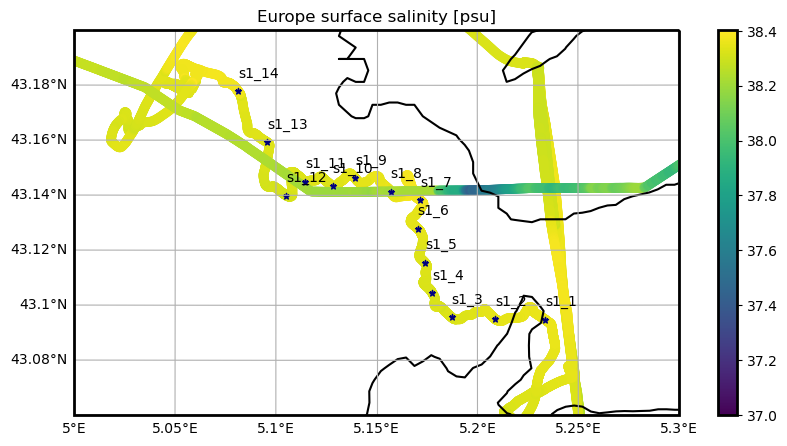

In [10]:
# plume area

kwargs_drifters = dict(extent=(5.0, 5.3, 43.06, 43.2), bathy=kwargs_map["bathy"])

fac = pin.maps.plot_map(**kwargs_drifters, bathy_levels=cp.bathy["levels"])
fig, ax = fac["fig"], fac["ax"]
im = ax.scatter(da.lon, da.lat, c=da, transform=crs, vmin=37)
fig.colorbar(im, ax=ax)
ax.set_title("Europe surface salinity [psu]")

ax.scatter(
    [d.start.lon for d in cp["ctd_europe"]],
    [d.start.lat for d in cp["ctd_europe"]],
    s=20,
    c="navy",
    edgecolor=None,
    marker="*",
    transform=crs,
)

for d in cp["ctd_europe"]:
    if d.label[1] == "1":
        ax.annotate(d.label, (d.start.lon, d.start.lat + 0.005), transform=crs)

### profiles

#### plot utils

In [11]:
dkwargs = dict(
    temperature=dict(vmin=13, vmax=24, delta=0.0),
    salinity=dict(vmin=37, vmax=39, delta=0.0),
    turbidity=dict(vmin=None, vmax=None, delta=0.0),
    fluorescence=dict(vmin=None, vmax=None, delta=0.0),
)


def plot_cast_superimposed(label_filter=None, **kwargs):

    labels = []
    for d, ds in D.items():
        if label_filter is None or label_filter(d):
            labels.append(d)
    N = len(labels)
    colors = pin.get_cmap_colors(N)

    # fig, axes = plt.subplots(4,1, figsize=(5,10))
    fig, axes = plt.subplots(1, 4, figsize=(10, 5), sharey=True)

    for i, v in enumerate(list(dkwargs)):
        ax = axes[i]
        _kwargs = dkwargs[v]
        if v in kwargs:
            _kwargs.update(**kwargs[v])
        for j, d in enumerate(labels):
            ds = D[d]
            (ds[v] + j * _kwargs["delta"]).plot.line(ax=ax, y="z", color=colors[j])
        ax.grid()
        ax.set_xlim(_kwargs["vmin"], _kwargs["vmax"])
        # ax.set_xlabel("")
        ax.set_title(v)
        if i > 0:
            ax.set_ylabel("")

In [12]:
dkwargs = dict(
    temperature=dict(vmin=13, vmax=22.5, xticks_minor=2.5, xticks_major=5),
    salinity=dict(vmin=37.5, vmax=38.5, xticks_minor=0.25, xticks_major=0.5),
    turbidity=dict(vmin=0, vmax=10, xticks_minor=2.0, xticks_major=4),
    fluorescence=dict(vmin=-0.5, vmax=4, xticks_minor=1.0, xticks_major=2),
)


def plot_cast_split(label_filter=None, **kwargs):

    labels = []
    for d, ds in D.items():
        if label_filter is None or label_filter(d):
            labels.append(d)
    N = len(labels)
    colors = pin.get_cmap_colors(N)

    fig, axes = plt.subplots(4, N, figsize=(15, 10), sharey=True)

    for i, v in enumerate(list(dkwargs)):
        _kwargs = dkwargs[v]
        if v in kwargs:
            _kwargs.update(**kwargs[v])
        for j, d in enumerate(labels):
            ax = axes[i, j]
            ds = D[d]
            ds[v].plot.line(ax=ax, y="z", color=colors[j])
            ax.set_xlim(_kwargs["vmin"], _kwargs["vmax"])
            if "xticks_major" in _kwargs:
                ax.xaxis.set_major_locator(MultipleLocator(_kwargs["xticks_major"]))
                # ax.xaxis.set_major_formatter('{x:.1f}')
            if "xticks_minor" in _kwargs:
                # ax.set_xticklabels(_kwargs["xticks"])
                # For the minor ticks, use no labels; default NullFormatter.
                ax.xaxis.set_minor_locator(MultipleLocator(_kwargs["xticks_minor"]))
            if i == 0:
                ax.set_title(d)
            ax.set_xlabel("")
            if j == 0:
                ax.set_ylabel(v)
            else:
                ax.set_ylabel("")
            for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(8)
            ax.grid(which="both")

#### focus on Plume

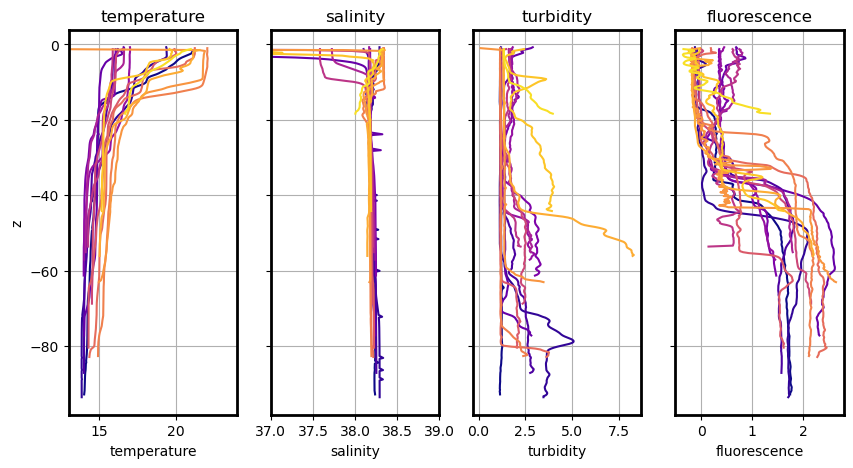

In [13]:
label_filter = lambda label: label[1] == "0" and label != "s0_1"

kwargs = dict(
    temperature=dict(vmin=13, vmax=24, delta=0.0),
    salinity=dict(vmin=37, vmax=39, delta=0.0),
    turbidity=dict(vmin=None, vmax=None, delta=0.0),
    fluorescence=dict(vmin=None, vmax=None, delta=0.0),
)

plot_cast_superimposed(label_filter, **kwargs)

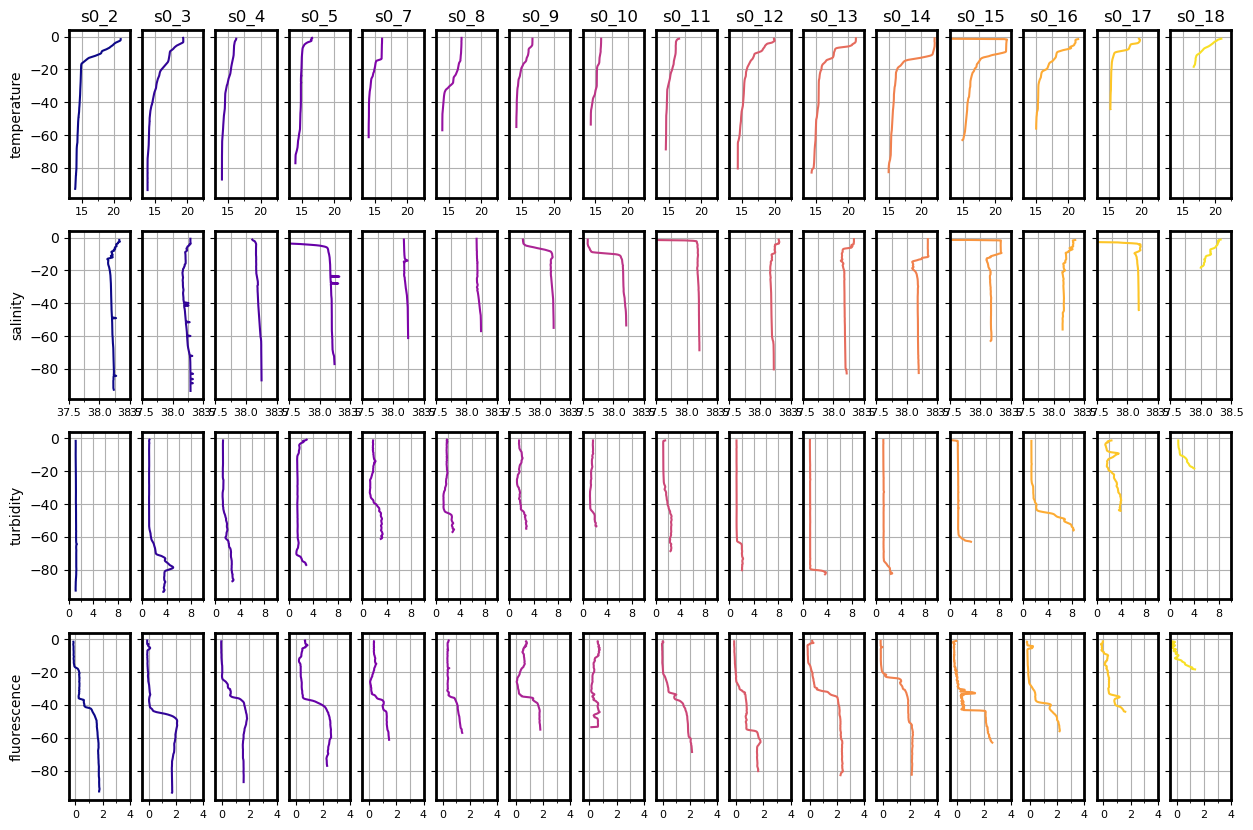

In [14]:
label_filter = lambda label: label[1] == "0" and label != "s0_1"

kwargs = dict(
    temperature=dict(vmin=13, vmax=22.5, xticks_minor=2.5, xticks_major=5),
    salinity=dict(vmin=37.5, vmax=38.5, xticks_minor=0.25, xticks_major=0.5),
    turbidity=dict(vmin=0, vmax=10, xticks_minor=2.0, xticks_major=4),
    fluorescence=dict(vmin=-0.5, vmax=4, xticks_minor=1.0, xticks_major=2),
)

plot_cast_split(label_filter, **kwargs)

#### focus on drifter deployment

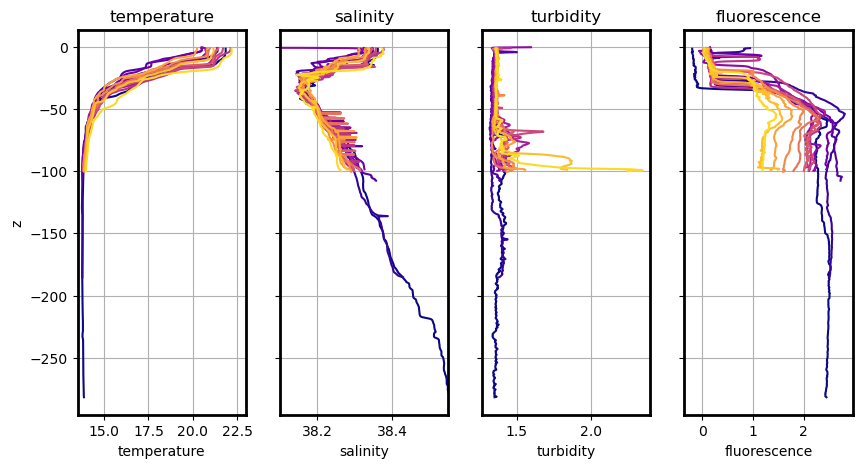

In [15]:
label_filter = lambda label: label[1] == "1"

kwargs = dict(
    temperature=dict(vmin=13.5, vmax=23, delta=0.0),
    salinity=dict(vmin=38.1, vmax=38.55, delta=0.0),
    turbidity=dict(vmin=None, vmax=None, delta=0.0),
    fluorescence=dict(vmin=None, vmax=None, delta=0.0),
)

plot_cast_superimposed(label_filter, **kwargs)

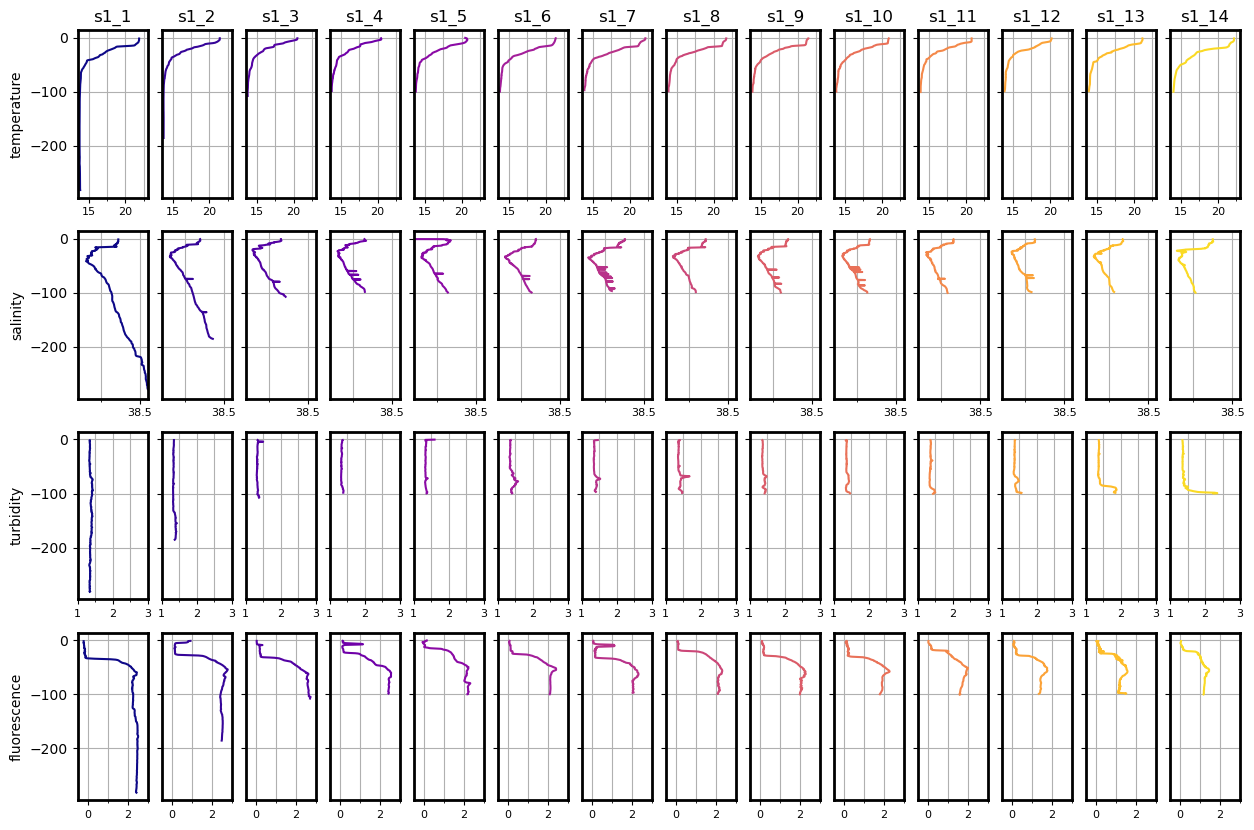

In [16]:
label_filter = lambda label: label[1] == "1"

kwargs = dict(
    temperature=dict(vmin=13.5, vmax=23, xticks_minor=2.5, xticks_major=5),
    salinity=dict(vmin=38.1, vmax=38.55, xticks_minor=0.25, xticks_major=0.5),
    turbidity=dict(vmin=1, vmax=3, xticks_minor=0.5, xticks_major=1),
    fluorescence=dict(vmin=-0.5, vmax=3, xticks_minor=1.0, xticks_major=2),
)

plot_cast_split(label_filter, **kwargs)